In [206]:
#imports
import pandas as pd
import numpy as np
import cvxpy as cp

The first step of the assignment is cleaning the data.

We decided to use only the last 20 years of data to calulate industries' expected returns and standard deviation. We explain these choices in the report.

In [207]:
# importing and printing dataframe
# importing dataframe of data
imported_data = pd.read_csv("48_Portfolios.CSV", index_col=0)

# Convert the index to datetime format
imported_data.index = pd.to_datetime(imported_data.index, format='%Y-%m-%d')

# filtering data for the last 20 years only
last_date = imported_data.index[-1]
start_date = last_date - pd.DateOffset(years=20)
imported_data = imported_data[start_date:]

# transforming return from percentages to decimals
original_data = imported_data/100
print(original_data)

             Agric    Food    Soda    Beer   Smoke    Toys     Fun   Books  \
Date                                                                         
2003-07-31  0.0214  0.0019  0.0114 -0.0184 -0.1130  0.0428 -0.0145 -0.0139   
2003-08-31  0.0273 -0.0053  0.0795 -0.0205  0.0253  0.0337  0.0480  0.0077   
2003-09-30  0.0083  0.0213 -0.0347 -0.0155  0.0810 -0.0083 -0.0330 -0.0016   
2003-10-31  0.1124  0.0386  0.0609  0.0571  0.0613  0.1210  0.0325  0.0773   
2003-11-30  0.0603  0.0227  0.0321  0.0235  0.1159  0.0163  0.0579  0.0179   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2023-03-31 -0.0264  0.0345  0.0515  0.0415  0.0011 -0.0123  0.0304 -0.0380   
2023-04-30  0.0002  0.0293  0.0342  0.0418  0.0410 -0.0307  0.0079  0.0173   
2023-05-31 -0.1094 -0.0500 -0.0382 -0.0285 -0.0873 -0.0847  0.0355 -0.0064   
2023-06-30  0.0632 -0.0074  0.0137  0.0279  0.0777  0.1073  0.0938  0.0603   
2023-07-31 -0.0094  0.0211  0.0215  0.0324  0.0149  0.0698  0.01

In [208]:
# filtering for the 5 randomly chosen assets
assets = ["Fun","Food","Trans","Drugs","Banks"]
data = original_data[assets]

# filtering for the 20 randomly chosen assets
new_industries = ["Agric","Food","Beer","Smoke","Toys","Fun","Books","Trans","Whlsl","Rtail","Meals","Banks",
                  "Insur","RlEst","Fin","Other","Oil","Drugs","Comps","Chips"] 
data_20_assets = original_data[new_industries]


# filtering for all the assets
industry_names = [col for col in original_data.columns if col != 'Date'] 
assets_all = original_data[industry_names]



# Extract covariance matrix
cov_m = data.cov()
cov_m_20 = data_20_assets.cov()
cov_m_48 = assets_all.cov()
print("Covariance Matrix:")
print(cov_m)

# calculating inverse of covariance matrix
temp = np.linalg.inv(cov_m)
cov_m_inv = cov_m.copy(deep = True)
# making a copy of the inversed covariance matrix to keep the same format
for i in range(0,5):
    for j in range(0,5):
        cov_m_inv.iloc[i,j] = temp[i,j]

print("\nInversed Covariance Matrix:")
print(cov_m_inv)

Covariance Matrix:
            Fun      Food     Trans     Drugs     Banks
Fun    0.006972  0.001374  0.003317  0.001604  0.003635
Food   0.001374  0.001294  0.001108  0.000784  0.001171
Trans  0.003317  0.001108  0.003279  0.001215  0.002786
Drugs  0.001604  0.000784  0.001215  0.001620  0.001329
Banks  0.003635  0.001171  0.002786  0.001329  0.004223

Inversed Covariance Matrix:
              Fun         Food       Trans        Drugs       Banks
Fun    312.845964   -31.077764 -178.375376   -58.963994 -124.402907
Food   -31.077764  1268.401278 -187.664607  -374.184700  -83.469241
Trans -178.375376  -187.664607  877.706135  -113.647891 -337.653073
Drugs  -58.963994  -374.184700 -113.647891  1016.421641  -90.424069
Banks -124.402907   -83.469241 -337.653073   -90.424069  618.211051


To estimate returns, we decided to use an exponetial smoothing function  over the last 10 years (120 periods)

In [209]:
# Forecasting returns with an exponential smoothing function
# Create an empty DataFrame to store EMA values as well as EMA_20 values used for Q3
ema = pd.DataFrame()
ema_20 = pd.DataFrame()
ema_48 = pd.DataFrame()

# Loop over each column to calculate its EMA for 5 industries (Q1 and Q2)
span_value = 120
for col in data.columns:
    ema_values = data[col].ewm(span=span_value, adjust=False).mean()
    ema[f"{col}"]= [ema_values.iloc[-1]]

ema = (ema+1)**12 - 1

# Loop over each column to calculate its EMA for 20 industreis (Q3)
for col in data_20_assets.columns:
    ema_values = data_20_assets[col].ewm(span=span_value, adjust=False).mean()
    ema_20[f"{col}"]= [ema_values.iloc[-1]]

ema_20 = (ema_20+1)**12 - 1

# Loop over each column to calculate its EMA for 48 industreis (Q5)
for col in assets_all.columns:
    ema_values = assets_all[col].ewm(span=span_value, adjust=False).mean()
    ema_48[f"{col}"]= [ema_values.iloc[-1]]

ema_48 = (ema_48+1)**12 - 1

print('Annualized expected returns of chosen industries:')
print(ema)

# Convert the DataFrame to a NumPy array
z_mean = ema.values[0]
z_mean_20 = ema_20.values[0]
z_mean_48 = ema_48.values[0]

Annualized expected returns of chosen industries:
        Fun      Food     Trans    Drugs    Banks
0  0.141344  0.082114  0.131644  0.10476  0.10734


In [128]:
# Extracting annualized volatility of each industry
var = np.diag(cov_m)
vol_ann = np.sqrt(var)*np.sqrt(12) # annualized volatility

print('Annualized standard deviation of returns:')
print(vol_ann)

Annualized standard deviation of returns:
[0.28923921 0.12463442 0.19837162 0.13941683 0.22511403]


In [210]:
# Let's introduce simplifying variable, as seen in class
I_arr = np.array([1, 1, 1, 1, 1])

print('Let\'s introduce simplifying variable, as seen in class:')

# A
A = np.dot(I_arr.transpose(), cov_m_inv) #matrix multiplications
A = np.dot(A, I_arr)
print('A = ', A, '(which is > 0)')

# B
B = np.dot(I_arr.transpose(), cov_m_inv) #matrix multiplications
B = np.dot(B, z_mean)
print('B = ', B)


# C
C = np.dot(z_mean.transpose(), cov_m_inv) #matrix multiplications
C = np.dot(C, z_mean)
print('C = ', C, '(which is > 0)')


Let's introduce simplifying variable, as seen in class:
A =  933.8588212088533 (which is > 0)
B =  83.07537642265854
C =  8.733409974038624 (which is > 0)


Question 1:

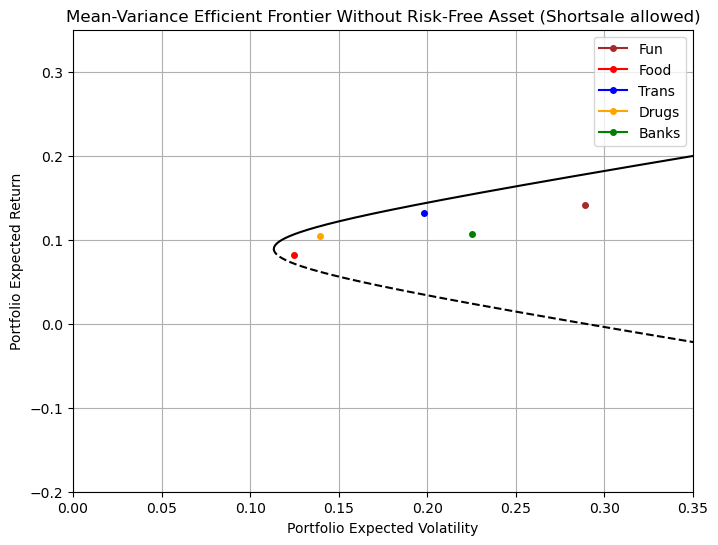

In [211]:
# Q1 A) No risk-free asset
# ************ Numerical Solution Method ************

# declaring a list of target returns to calculate minimum variance for
returns_list = np.linspace(-0.2, 0.55, 1501).tolist()

# variance function in terms of target return function with no riskfree asset
def sigmaSquared(x):
    return np.sqrt((A*(x**2)-(2*B*x)+C)/(A*C-(B**2)))*np.sqrt(12)

# Calculate corresponding y values by applying the function to x
sigma_list = [] #creating empty list
for x in returns_list:
    sigma_list.append(sigmaSquared(x))

# Plotting the Efficient Frontier curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title("Mean-Variance Efficient Frontier Without Risk-Free Asset (Shortsale allowed)")
plt.xlabel('Portfolio Expected Volatility')
plt.ylabel('Portfolio Expected Return')
plt.xlim(0, 0.35)
plt.ylim(-0.2, 0.35)
# Finding the minimum variance index for graphing purposes
minSigma = sigma_list.index(min(sigma_list))
plt.plot(sigma_list[minSigma:], returns_list[minSigma:], color='black')
plt.plot(sigma_list[:minSigma], returns_list[:minSigma], color='black', linestyle='dashed')
plt.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='brown', label='Fun')
plt.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
plt.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
plt.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Drugs')
plt.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='green', label='Banks')
plt.legend()


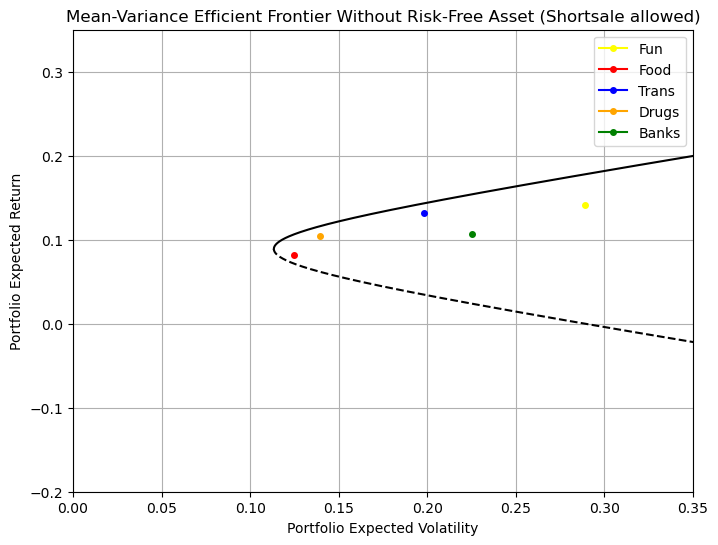

In [212]:
# Q1 A) No risk-free asset
# ************ Dynamic Solver Method ************

# imports
import cvxpy as cp

n = len(z_mean)  # Number of assets
w = cp.Variable(n)  # Portfolio weights

# defining objective function
Var_Output = cp.quad_form(w,cov_m)

# defining constraint function for dynamic solver
def constraints(targetReturn):
    return [I_arr.T @ w == 1, z_mean.T @ w == targetReturn]

# Define a range of target returns for the efficient frontier
targetReturns_list = np.linspace(-0.2, 0.55, 1501).tolist()

# Declaring list to hold expected standard deviation and weight concentration outputs of optimizer
sigma_list2 = []
test = []
for tr in targetReturns_list:
    # Formulate the optimization problem
    problem_noRf = cp.Problem(cp.Minimize(Var_Output), constraints(tr))

    # Optimizing to find solution
    problem_noRf.solve()

    # append solution to list of sigmas
    sigma_list2.append(np.sqrt(problem_noRf.value)*np.sqrt(12))
    test.append(np.max(w.value))
# Plotting the Efficient Frontier curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title("Mean-Variance Efficient Frontier Without Risk-Free Asset (Shortsale allowed)")
plt.xlabel('Portfolio Expected Volatility')
plt.ylabel('Portfolio Expected Return')
plt.xlim(0, 0.35)
plt.ylim(-0.2, 0.35)
plt.plot(sigma_list2[minSigma:], targetReturns_list[minSigma:], color='black')
plt.plot(sigma_list2[:minSigma], targetReturns_list[:minSigma], color='black', linestyle='dashed')
plt.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='yellow', label='Fun')
plt.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
plt.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
plt.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Drugs')
plt.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='green', label='Banks')
plt.legend()


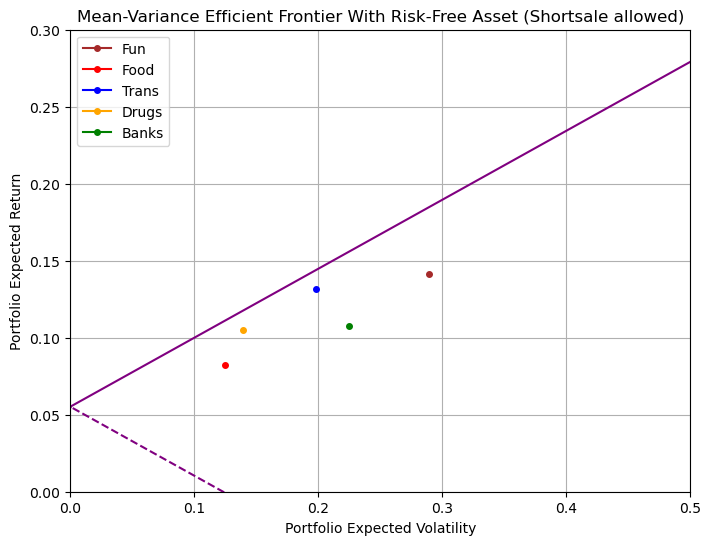

In [213]:
#Q1 B) risk-free asset
# 1-month risk free rate as of september 22
# https://ycharts.com/indicators/1_month_treasury_rate#:~:text=1%20Month%20Treasury%20Rate%20is%20at%205.53%25%2C%20compared,the%20previous%20market%20day%20and%202.57%25%20last%20year.
Rf = 0.0552

# variance in terms of target return function with riskfree asset
def sigmaSquared_rf(x):
    return np.sqrt((x-Rf)**2/(C-2*Rf*B+Rf**2*A))*np.sqrt(12)

# Calculate corresponding y values by applying the function to x
sigma_list3 = [] #creating empty list
for x in returns_list:
    sigma_list3.append(sigmaSquared_rf(x))


# Create a plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title("Mean-Variance Efficient Frontier With Risk-Free Asset (Shortsale allowed)")
plt.xlabel('Portfolio Expected Volatility')
plt.ylabel('Portfolio Expected Return')
# Finding the minimum variance index for graphing purposes
minSigma3 = sigma_list3.index(min(sigma_list3))
plt.plot(sigma_list3[minSigma3:], returns_list[minSigma3:], color='purple')
plt.plot(sigma_list3[:minSigma3], returns_list[:minSigma3], color='purple', linestyle='dashed')
plt.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='brown', label='Fun')
plt.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
plt.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
plt.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Drugs')
plt.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='green', label='Banks')
plt.xlim(0, 0.5)
plt.ylim(0, 0.30)
plt.legend()

The tangency portfolio is made of the following weights (and sums to 1): 
[ 0.09735279 -0.18340869  0.74352316  0.69214918 -0.34961645]
Reminder: industries are Fun, Food, Drugs, Chem, Banks
Which yields an expected return of 0.13156126957687256
And an expected volatility of 0.17048658540710906


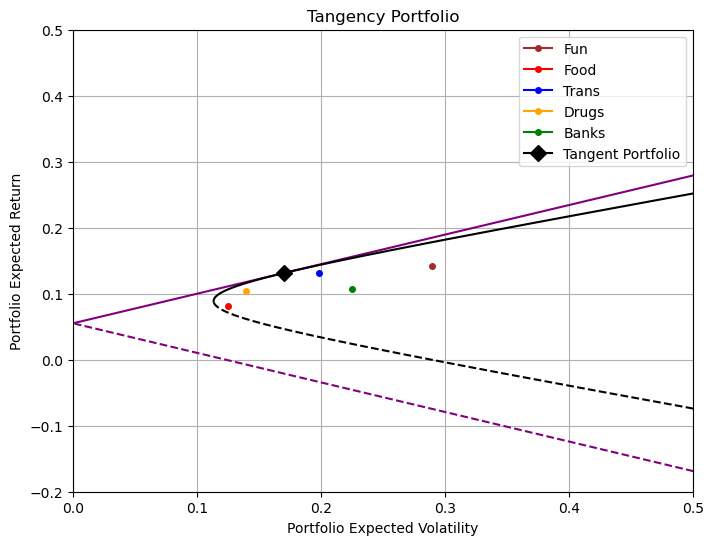

In [214]:
# Question 1 C)

# Tangency portfolio is given by:
# Tangency portfolio weights:
w_tangent = np.dot(cov_m_inv,(z_mean-Rf*I_arr))/(B-A*Rf)
# Tangency portfolio variance:
sigma_tangent = np.sqrt((C - 2*B*Rf + A * Rf**2) / (B-A*Rf)**2)*np.sqrt(12)
print("The tangency portfolio is made of the following weights (and sums to 1): ")
print(w_tangent)
print("Reminder: industries are Fun, Food, Drugs, Chem, Banks")
print("Which yields an expected return of", (np.dot(w_tangent.transpose(),z_mean)).sum())
print("And an expected volatility of", sigma_tangent)


# Plotting the tangency portfolio
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title("Tangency Portfolio")
plt.xlabel('Portfolio Expected Volatility')
plt.ylabel('Portfolio Expected Return')
plt.plot(sigma_list3[minSigma3:], returns_list[minSigma3:], color='purple')
plt.plot(sigma_list3[:minSigma3], returns_list[:minSigma3], color='purple', linestyle='dashed')
plt.plot(sigma_list[minSigma:], returns_list[minSigma:], color='black')
plt.plot(sigma_list[:minSigma], returns_list[:minSigma], color='black', linestyle='dashed')
plt.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='brown', label='Fun')
plt.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
plt.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
plt.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Drugs')
plt.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='green', label='Banks')
plt.plot(sigma_tangent, (np.dot(w_tangent.transpose(),z_mean)).sum(), marker='D', markersize=8, color='black', label='Tangent Portfolio')
plt.xlim(0, 0.5)
plt.ylim(-0.2, 0.5)
plt.legend()

# Q1 D)
How and why did the mean-variance efficient frontier change with the introduction of a risk-free asset?

Answer: Adding the risk-free asset to the portfolio improves the efficient frontier in comparison to the previous portfolio in terms of expected returns versus expected volatility. This phenomenon is due to the addition of a riskless asset with a guaranteed return, zero volatility and zero correlation with the risky assets. As such, the universe of feasible portfolio increased positively in terms of expected returns with respect to expected volatility. Additionally, we note that the mean-variance efficient frontier for the portfolio with a riskless asset is characterized by a linear function instead of a quadratic function. This is attributed to the portfolio being a linear combination of the best risky portfolio and the risk-free asset.


Question 2:

/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


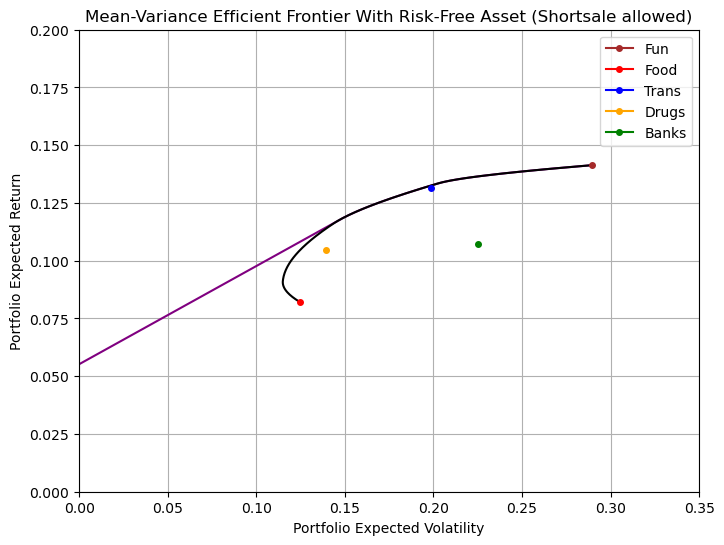

In [215]:
# Q2 A)

# imports
import cvxpy as cp

n = len(z_mean)  # Number of assets
w = cp.Variable(n)  # Portfolio weights

# Objective function: Minimize expected variance
Var_Output = cp.quad_form(w,cov_m)

# Helper function to build the constraints list for the optimization
def constraints_rf(targetReturn, RiskFreeAsset):

    if RiskFreeAsset == 'No':
        # inputs the constraints:
        # --- 1*w == 1
        # --- z^T * w == target Return
        # --- w >= 0
        constraints = [I_arr.T @ w == 1,
                       z_mean.T @ w == targetReturn,
                       w>=0]
    else:
        # inputs the constraints:
        # --- 1*w <= 1
        # --- (z-R*I)^T * w == target Return - Rf
        # --- w >= 0
        constraints = [I_arr.T @ w <= 1,
                       (z_mean - Rf*I_arr).T @ w == targetReturn-Rf,
                       w>=0]

    return constraints

# Formulate the optimization problem
problem = cp.Problem(cp.Minimize(Var_Output), constraints_rf(0.125, RiskFreeAsset = 'No'))

# Define a range of target returns for the efficient frontier
targetReturns_list = np.linspace(-0.25, 0.25, 1501).tolist()

# Declaring list to hold expected standard deviation and weight concentration outputs of optimizer
sigma_list_noRf = []
sigma_list_withRf = []
weight_list_noRf_ss = []
weight_list_withRf_ss = []

# for loop to calculate frontier with solver
for tr in targetReturns_list:
    # Formulate the optimization problem
    problem_noRf = cp.Problem(cp.Minimize(Var_Output), constraints_rf(tr, RiskFreeAsset = 'No'))
    problem_withRf = cp.Problem(cp.Minimize(Var_Output), constraints_rf(tr, RiskFreeAsset = 'Yes'))

    # Optimizing to find solution
    problem_noRf.solve()
    weight_list_noRf_ss.append(w.value) # recording weights concentration for question 2 d)
    problem_withRf.solve()
    weight_list_withRf_ss.append(w.value) # recording weights concentration for question 2 d)

    # append solution to list of sigmas
    sigma_list_noRf.append(np.sqrt(problem_noRf.value)*np.sqrt(12))
    sigma_list_withRf.append(np.sqrt(problem_withRf.value)*np.sqrt(12))


# Plotting the frontier portfolio with risk-less asset
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title("Mean-Variance Efficient Frontier With Risk-Free Asset (Shortsale allowed)")
plt.xlabel('Portfolio Expected Volatility')
plt.ylabel('Portfolio Expected Return')
plt.plot(sigma_list_withRf, targetReturns_list, color='purple')
plt.plot(sigma_list_noRf, targetReturns_list, color='black')
plt.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='brown', label='Fun')
plt.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
plt.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
plt.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Drugs')
plt.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='green', label='Banks')
plt.xlim(0, 0.35)
plt.ylim(0.00, 0.20)
plt.legend()

# 2 B)
Can you find a tangency portfolio under "no short-sale" constraints? If so, show its weights and
identify the portfolio on the mean-variance frontier.

Answer: There are no tangency portfolio under the "no short-sale" constraints. This is due to the portfolio with risk-free asset not having a linear mean-variance efficient frontier due to its inability to sell the risky portfolio to buy the risk-free asset. As such, as the target return increases over the risk free rate, the most variance-efficient portfolio contains more of the risky portfolio, at the expense of its allocation to the risk free asset. Beyond a target return of approximately 12%, the portfolio with risk-free asset contains only the risky assets and no risk-free asset, which has the same mean-variance efficient frontier as the portfolio with no risk-free asset.

# 2 C)
How and why did the mean-variance efficient frontiers change with the introduction of "no shortsale" constraints?

Answer: In the below chart, we display the mean-variance efficient frontiers with short sale in red and the frontier with no short sale in green. The universe of feasible portfolios were reduced with the constraint of no short-sale, as such, the mean-variance efficent frontier was shifted to the right (worse variance for the same expected returns). Additionally, the mean-variance efficient frontier is shortened, due to the inability of using leverage by shorting the risk-free asset and investing the proceeds in the risky portfolio, or vice-versa.

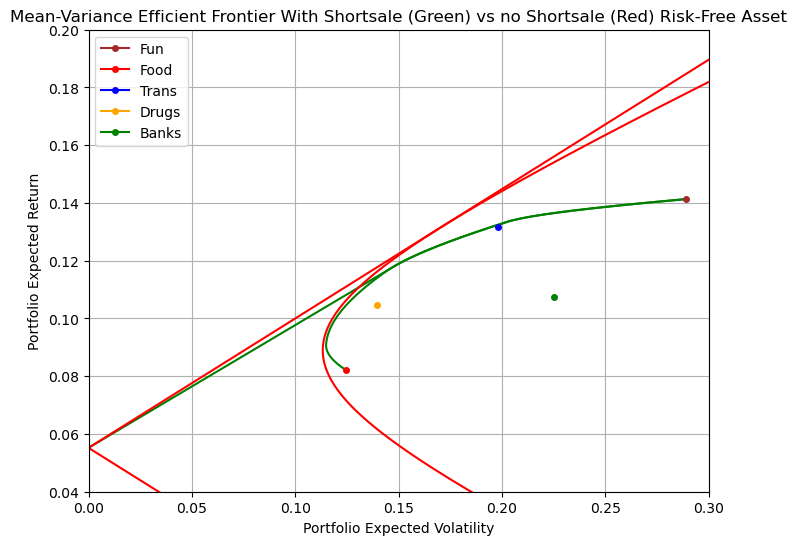

In [135]:
# Create a plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title("Mean-Variance Efficient Frontier With Shortsale (Red) vs no Shortsale (Green) Risk-Free Asset")
plt.xlabel('Portfolio Expected Volatility')
plt.ylabel('Portfolio Expected Return')
#saving variables for q3:
Sigma_q3b, targetReturns_q3b = sigma_list_withRf, targetReturns_list 
plt.plot(sigma_list_withRf, targetReturns_list, color='green')
plt.plot(sigma_list_noRf, targetReturns_list, color='green')
plt.plot(sigma_list3, returns_list, color='red')
plt.plot(sigma_list2, returns_list, color='red')
plt.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='brown', label='Fun')
plt.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
plt.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
plt.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Drugs')
plt.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='green', label='Banks')
plt.xlim(0, 0.3)
plt.ylim(0.04, 0.20)
plt.legend()

# 2 D)
Do mean-variance efficient portfolios become more or less concentrated with the introduction of
"no short-sale" constraints?


In [62]:
# Declaring list to hold expected standard deviation outputs of optimizer
weight_list_noRf = []
weight_list_withRf = []
temp_noRF = []
temp_withRF = []

# Objective function: Maximize expected return (mu^T * weights)
Var_Output = cp.quad_form(w,cov_m)

for tr in targetReturns_list:
    # Formulate the optimization problem
    problem_noRf = cp.Problem(cp.Minimize(Var_Output), constraints_rf(tr, RiskFreeAsset = 'No'))
    problem_withRf = cp.Problem(cp.Minimize(Var_Output), constraints_rf(tr, RiskFreeAsset = 'Yes'))

    # Optimizing to find solution
    problem_noRf.solve()
    # append max weight to list of sigmas
    weight_list_noRf.append(np.max(w.value))
    # append temporary solution to find min var
    temp_noRF.append(problem_noRf.value)
    # running the optimization problem
    problem_withRf.solve()
    # append max weight to list of sigmas
    weight_list_withRf.append(np.max(w.value))
    # append temporary solution to find min var
    temp_withRF.append(problem_withRf.value)
# adjusting to consider weight in riskfree asset
for x in range(0,len(weight_list_withRf[:1096])):
    if weight_list_withRf[x] is not None:
        weight_list_withRf[x] = 1-weight_list_withRf[x]


# Helper function to build the constraints list for the optimization
def constraints_rf_ss(targetReturn, RiskFreeAsset):

    if RiskFreeAsset == 'No':
        # inputs the constraints:
        # --- 1*w == 1
        # --- z^T * w == target Return
        # --- w >= 0
        constraints = [I_arr.T @ w <= 1,
                       z_mean.T @ w == targetReturn]
    else:
        # inputs the constraints:
        # --- 1*w <= 1
        # --- (z-R*I)^T * w == target Return - Rf
        # --- w >= 0
        constraints = [I_arr.T @ w <= 1,
                       (z_mean - Rf*I_arr).T @ w == targetReturn-Rf]

    return constraints

# setting empty lists
weight_list_noRf_ss = []
weight_list_withRf_ss = []
temp_noRF = []
temp_withRF = []

for tr in targetReturns_list:
    # Formulate the optimization problem
    problem_noRf = cp.Problem(cp.Minimize(Var_Output), constraints_rf_ss(tr, RiskFreeAsset = 'No'))
    problem_withRf = cp.Problem(cp.Minimize(Var_Output), constraints_rf_ss(tr, RiskFreeAsset = 'Yes'))

    # Optimizing to find solution
    problem_noRf.solve()
    # append max weight to list of sigmas
    weight_list_noRf_ss.append(np.max(w.value))
    # append temporary solution to find min var
    temp_noRF.append(problem_noRf.value)
    # running the optimization problem
    problem_withRf.solve()
    # append max weight to list of sigmas
    weight_list_withRf_ss.append(np.max(w.value))
    # append temporary solution to find min var
    temp_withRF.append(problem_withRf.value)

/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [216]:
# Creating functions that finds the cocentration of the portfolio without shortsaling and with a riskfree asset
n = len(z_mean)  # Number of assets
w = cp.Variable(n)  # Portfolio weights

# defining objective function
Var_Output = cp.quad_form(w,cov_m)

# defining constraint function for dynamic solver
def constraints(targetReturn):
    return [I_arr.T @ w == 1, z_mean.T @ w == targetReturn]

# Define a range of target returns for the efficient frontier
targetReturns_list_temp = np.linspace(-0.2, 0.55, 1501).tolist()

# Declaring list to hold expected standard deviation and weight concentration outputs of optimizer
weight_list_noRf_ss = []
for tr in targetReturns_list_temp:
    # Formulate the optimization problem
    problem_noRf = cp.Problem(cp.Minimize(Var_Output), constraints(tr))

    # Optimizing to find solution
    problem_noRf.solve()

    # append solution to list of sigmas
    weight_list_noRf_ss.append(np.max(w.value))

In [217]:
# Creating functions that finds the cocentration of the portfolio with shortsaling and a riskfree asset
# It takes as input, the target return of the portfolio, the return maximum weight
def Mean_Variance_Portfolio(target_return, Cov, Z_Asset_Returns):
    CP_Weight = cp.Variable(len(Z_Asset_Returns))
    objective = cp.Minimize(CP_Weight.T @ Cov @ CP_Weight)
    constraints = [cp.sum(CP_Weight) == 1,
                   CP_Weight.T @ Z_Asset_Returns - target_return == 0]
    problem = cp.Problem(objective, constraints)
    variance = problem.solve()
    #Opt_weights = CP_Weight.value
    volatility = np.sqrt(variance)
    return np.max(CP_Weight.value)

#adding the Risk-free rate to cov matrix
selected_assets_1b = data
selected_assets_1b["Rf"] = Rf
cov_table_1b = selected_assets_1b.cov()*12
cov_matrix_1b = cov_table_1b.values

#adding rf to returns
asset_returns_vector_1b = np.append(z_mean, Rf)

# function to measure concentration of the portfolio for frontier with shortsale and riskfree asset
weight_list_withRf_ss = [] #creating empty list
for x in returns_list:
    weight_list_withRf_ss.append(Mean_Variance_Portfolio(x,cov_matrix_1b, asset_returns_vector_1b))

/var/folders/3f/y8bsjl_d3hd3nds4_rlrfctr0000gn/T/ipykernel_53631/2460655239.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_assets_1b["Rf"] = Rf


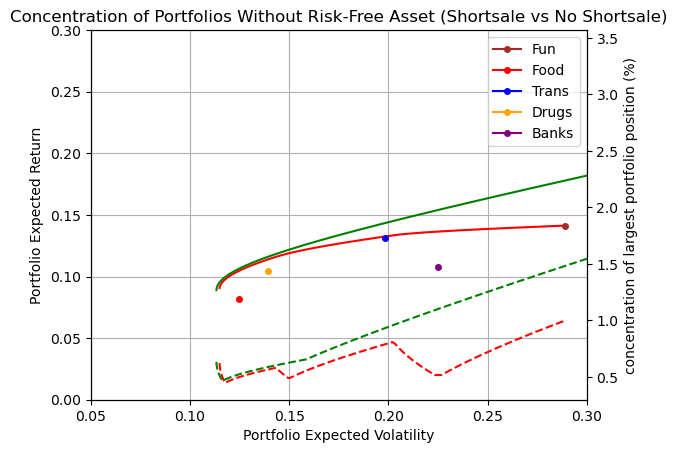

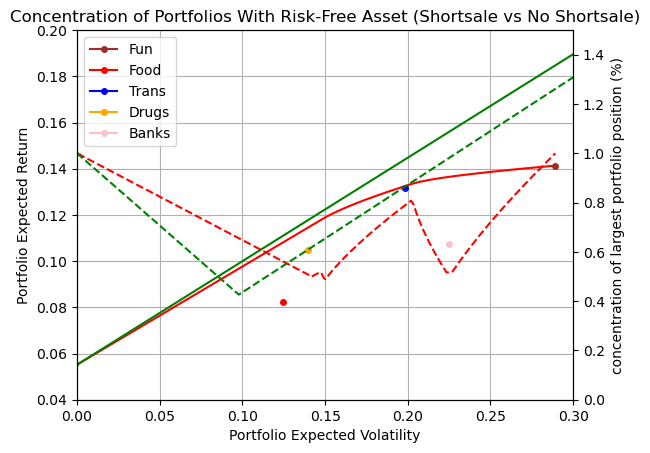

In [218]:
# Create a plot with 2 y-axis
temp, chart = plt.subplots()
subchart = chart.twinx()
chart.grid(True )
plt.title("Concentration of Portfolios Without Risk-Free Asset (Shortsale vs No Shortsale)")
chart.set_xlabel('Portfolio Expected Volatility')
chart.set_ylabel('Portfolio Expected Return')
subchart.set_ylabel('concentration of largest portfolio position (%)')
# plotting frontier with no shortsale
# Finding the minimum variance index for graphing purposes
minSigma4 = sigma_list_noRf.index(min(sigma_list_noRf))
chart.plot(sigma_list_noRf[minSigma4:], targetReturns_list[minSigma4:], color='red')
subchart.plot(sigma_list_noRf[minSigma4:], weight_list_noRf[minSigma4:], color='red', linestyle='dashed')
# plotting frontier with shortsale
chart.plot(sigma_list[minSigma:], returns_list[minSigma:], color='green')
subchart.plot(sigma_list[minSigma:1000], weight_list_noRf_ss[minSigma:1000], color='green', linestyle='dashed')
chart.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='brown', label='Fun')
chart.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
chart.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
chart.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Drugs')
chart.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='purple', label='Banks')
chart.set_xlim(0.05, 0.3)
chart.set_ylim(0.00, 0.3)
chart.legend()

# Create a plot with 2 y-axis
temp, chart2 = plt.subplots()
subchart2 = chart2.twinx()
chart2.grid(True )
plt.title("Concentration of Portfolios With Risk-Free Asset (Shortsale vs No Shortsale)")
chart2.set_xlabel('Portfolio Expected Volatility')
chart2.set_ylabel('Portfolio Expected Return')
subchart2.set_ylabel('concentration of largest portfolio position (%)')
# Finding the minimum variance index for graphing purposes
# plotting frontier with no shortsale
chart2.plot(sigma_list_withRf, targetReturns_list, color='red')
subchart2.plot(sigma_list_withRf, weight_list_withRf, color='red', linestyle='dashed')
# plotting frontier with shortsale
chart2.plot(sigma_list3[minSigma3:], returns_list[minSigma3:], color='green')
subchart2.plot(sigma_list3[minSigma3:], weight_list_withRf_ss[minSigma3:], color='green', linestyle='dashed')
chart2.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='brown', label='Fun')
chart2.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
chart2.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
chart2.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Drugs')
chart2.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='pink', label='Banks')
chart2.set_xlim(0, 0.3)
chart2.set_ylim(0.04, 0.20)
subchart2.set_ylim(0.00, 1.5)
chart2.legend()


Ans: For the portfolios with no risk-free assets, the concentration in the portfolio with shortsale is slightly higher than the concentration of the portfolio with no shortsale. This is due to the universe of possible portfolios being larger where the mean-variance efficient portfolios for given expected volatility. These portfolios shortsale some less efficient assets to buy more efficient ones which create a noticeable increase in concentration as shown in the above graph.

For the portfolios with risk-free assets, we can make the general same conclusion. Additionally, we note the 'elbow' shape of the mean-variance efficient frontier with shortsale. This is due to the frontier being comprised of a linear combination of the risky portfolio and the riskless asset. For both portfolios, the concentration tends to be 100% of the risk-less asset when the expected target volatility is set at zero. As for the higher target volatilities, the portfolio tends to be more concentrated into the risky assets at the expense of the risk-less asset. We note that the portfolio with no short-sale is 100% invested in the 'Fun' industry at the highest feasible target volatility and the portfolio with shortsale can reach concentration of the risky portfolio higher than 100% by selling the riskless asset or other risky assets.


# 2 E)
What is the global maximum return the portfolio manager can expect? Describe the portfolio that attains this global maximum. Would you hold this portfolio in practice?

Answer: The portfolio with the global maximum return has an expected return of 14.13% and an annual volatility of 26.40%. This portfolio is comprised of a single asset: 100% invested in the "Fun" industry. A rational investor would not invest in this portfolio in practice, as they could reduce the non-systematic risk by diversifying its portfolio from a single asset investment.



Question 3:

# 3 A) 
Graph the mean-variance efficient frontiers with and without risk-free asset using 5 industry portfolios and using 20 industry portfolios.

In [219]:
#3 A) 
#These are the 20 new industries that were selected randomly
new_industries = ["Agric","Food","Beer","Smoke","Toys","Fun","Books","Trans","Whlsl","Rtail","Meals","Banks",
                  "Insur","RlEst","Fin","Other","Oil","Drugs","Comps","Chips"]
print(len(new_industries))

20


In the next part of the code we are graphing the 5 asset portfolio without risk-free asset and short selling in black and the 20 asset portfolio in red.

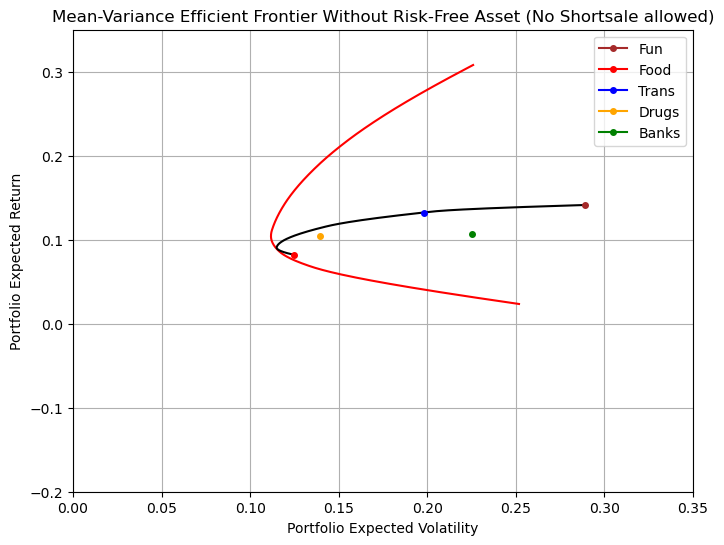

In [220]:
#Running the case without a risk-free asset
n = 20
I_arr = np.array([1]*n)
w = cp.Variable(n)  # Portfolio weights


# defining objective function
Var_Output = cp.quad_form(w,cov_m_20)

# defining constraint function for dynamic solver
def constraints(targetReturn):
    return [I_arr.T @ w == 1, z_mean_20.T @ w == targetReturn,w>=0]

# Define a range of target returns for the efficient frontier
targetReturns_list_q3 = np.linspace(-0.2, 0.55, 1501).tolist()

# Declaring list to hold expected standard deviation and weight concentration outputs of optimizer
sigma_list_q3 = []
test = []
for tr in targetReturns_list_q3:
    # Formulate the optimization problem
    problem_noRf = cp.Problem(cp.Minimize(Var_Output), constraints(tr))

    # Optimizing to find solution
    problem_noRf.solve()

    # append solution to list of sigmas
    sigma_list_q3.append(np.sqrt(problem_noRf.value)*np.sqrt(12))
    test.append(np.max(w.value))
# Plotting the Efficient Frontier curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title("Mean-Variance Efficient Frontier Without Risk-Free Asset (No Shortsale allowed)")
plt.xlabel('Portfolio Expected Volatility')
plt.ylabel('Portfolio Expected Return')
plt.xlim(0, 0.35)
plt.ylim(-0.2, 0.35)
plt.plot(sigma_list_q3, targetReturns_list_q3, color='red')
plt.plot(sigma_list_noRf, targetReturns_list, color='black')
plt.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='brown', label='Fun')
plt.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
plt.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
plt.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Drugs')
plt.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='green', label='Banks')
plt.legend()


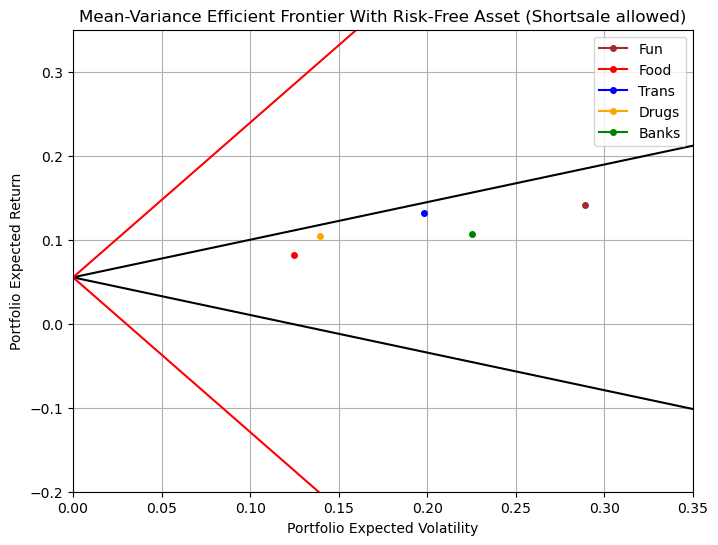

In [224]:
#Running the case with a risk-free asset

#Adding the risk free asset to our portfolio of 20 assets
cov_m_20_rf = cov_m_20.copy()
new_row = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
new_column = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
cov_m_20_rf.loc[20] = new_row
cov_m_20_rf["Rf"] = new_column
cov_m_20_rf = cov_m_20_rf.values
z_mean_20_rf = np.append(z_mean_20, Rf)


#defining the optimization function with the new constraints
def Mean_Variance_Portfolio_No_Short(target_return, Cov, Z_Asset_Returns):
    CP_Weight = cp.Variable(len(Z_Asset_Returns))
    objective = cp.Minimize(CP_Weight.T @ Cov @ CP_Weight)
    constraints = [cp.sum(CP_Weight) == 1, 
                   CP_Weight.T @ Z_Asset_Returns - target_return == 0]
    
    problem = cp.Problem(objective, constraints)
    variance = problem.solve()
    volatility = np.sqrt(variance)*np.sqrt(12)
    test = CP_Weight.value
    return volatility


returns_list_3 = np.linspace(-0.25, 0.35, 1501).tolist()

sigma_list_3a_rf = [] #creating empty list
for x in returns_list_3:
    sigma_list_3a_rf.append(Mean_Variance_Portfolio_No_Short(x,cov_m_20_rf, z_mean_20_rf))


# Plotting the Efficient Frontier curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title("Mean-Variance Efficient Frontier With Risk-Free Asset (Shortsale allowed)")
plt.xlabel('Portfolio Expected Volatility')
plt.ylabel('Portfolio Expected Return')
plt.xlim(0, 0.35)
plt.ylim(-0.2, 0.35)
plt.plot(sigma_list3, returns_list, color='black')
plt.plot(sigma_list_3a_rf, returns_list_3, color='red')
plt.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='brown', label='Fun')
plt.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
plt.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
plt.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Drugs')
plt.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='green', label='Banks')
plt.legend()





# 3 B) 
What is the impact of adding more industries to the risk-reward trade-offs?

Answer: Adding more risky assets to the portfolio improves the efficient frontier in both case in comparison to the previous portfolio in terms of expected returns versus expected volatility, the risk-reward trade-off improves. This phenomenon is due to the addition of more potential assets to diversify the risk. As such, the universe of feasible portfolio increased positively in terms of expected returns with respect to expected volatility. Additionally, we note that the mean-variance efficient frontier for the portfolio with 5 assets is contained inside the 20 assets as the 20 assets portfolio can always do better or at worse equal.

Question 4

# 4 A)
Using a brute force approach, graph the mean-variance efficient frontier with and without riskfree asset when the portfolio is allowed to hold a maximum of 3 industries out of 48. Are the
3 selected industries the same for all target returns? If not, analyze changes in the selection of
industries.

Note: The code takes a long time to run as it is brute force methode.

In [237]:
# imports needed for question 4
from itertools import combinations
import matplotlib.pyplot as plt
import cvxpy as cp
import statsmodels

 #Re importing data for code clarity 

# Importing and printing dataframe
data = pd.read_csv("48_Portfolios.CSV", index_col=0)

# Convert the index to datetime format
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
last_date = data.index[-1]
start_date = last_date - pd.DateOffset(years=20)

 

# Filtering for the last 20 years only
data = data[start_date:]
data = data/100
# Extract covariance matrix
cov_matrix = data.cov()

 

# Creating EMA

 

# Create an empty DataFrame to store EMA values
ema = pd.DataFrame()

 

# Loop over each column to calculate its EMA
span_value = 120
for col in data.columns:
    ema_values = data[col].ewm(span=span_value, adjust=False).mean()
    ema[f"{col}"]= [ema_values.iloc[-1]]
# Annualizing
ema = (ema+1)**12 - 1
# Make ema an array
ema = ema.values[0]

 

# Risk-fee rate
Rf = 0.0522

 

# Extracting annualized volatility of each industry
var = np.diag(cov_matrix)
vol_ann = np.sqrt(var)*np.sqrt(12) # annualized volatility

 

# Efficient Frontier
def constraints(targetReturn, RiskFreeAsset):
    I_arr_local = np.ones(len(ema_selected))  # Define a local identity array, so I has length 3 (not 48)
    if RiskFreeAsset == 'No':
        return [I_arr_local.T @ w == 1,
                ema_selected.T @ w == targetReturn,
                w >= 0]
    else:
        return [I_arr_local.T @ w <= 1,
                (ema_selected - Rf * I_arr_local).T @ w == targetReturn - Rf,
                w >= 0]

 

# Generate all combinations of 3 out of 48 industries
all_combinations = list(combinations(range(48), 3))

 

# Make a list to store results
results = []
targetReturns_list = np.linspace(-0.25, 0.25, 101).tolist()

 

# Initializing lists to store best sigma and combinations
best_combinations_noRf = [None] * len(targetReturns_list)
best_sigma_noRf = [float('inf')] * len(targetReturns_list)

 

best_combinations_withRf = [None] * len(targetReturns_list)
best_sigma_withRf = [float('inf')] * len(targetReturns_list)

 

# Loop through each combination of portfolios
for combo_index, combo in enumerate(all_combinations):
    print(f"{combo}")
    # Extract data for the 3 industries in the current combination
    ema_selected = ema[list(combo)]
    cov_m_array = cov_matrix.to_numpy()
    cov_m_selected = pd.DataFrame(cov_m_array[np.ix_(combo, combo)],
                                  index=cov_matrix.index[list(combo)],
                                  columns=cov_matrix.columns[list(combo)])

 

    n = len(ema_selected) # Number of assets
    w = cp.Variable(n) # Portfolio weights

 

    # Objective function: Maximize expected return (mu^T * weights)
    Var_Output = cp.quad_form(w, cov_m_selected)

 

    sigma_list_noRf = []
    sigma_list_withRf = []

 

    # For each target return, compute the efficient frontier
    for idx, tr in enumerate(targetReturns_list):
        try:
            problem_noRf = cp.Problem(cp.Minimize(Var_Output), constraints(tr, 'No'))
            problem_withRf = cp.Problem(cp.Minimize(Var_Output), constraints(tr, 'Yes'))

 

            problem_noRf.solve()
            problem_withRf.solve()

 

            sigma_noRf_current = np.sqrt(problem_noRf.value) * np.sqrt(12)
            sigma_withRf_current = np.sqrt(problem_withRf.value) * np.sqrt(12)

 

            if sigma_noRf_current < best_sigma_noRf[idx]:
                best_sigma_noRf[idx] = sigma_noRf_current
                best_combinations_noRf[idx] = combo

 

            if sigma_withRf_current < best_sigma_withRf[idx]:
                best_sigma_withRf[idx] = sigma_withRf_current
                best_combinations_withRf[idx] = combo
        except Exception as e:
            print(f"An error occurred for combination {combo} and target return {tr}: {e}")
            continue

 

# Check if the 3 selected industries are the same for all target returns
unique_combinations_noRf = set(best_combinations_noRf)
unique_combinations_withRf = set(best_combinations_withRf)

 

# Check if the industries change based on target returns
if len(unique_combinations_noRf) == 1 and len(unique_combinations_withRf) == 1:
    print("\nThe 3 selected industries are the same for all target returns.")
else:
    print("\nThe 3 selected industries change based on target returns.")

 

# Lists to track changes in combinations
change_combinations_noRf = []
change_combinations_withRf = []

 

prev_combo_noRf = best_combinations_noRf[0]
prev_combo_withRf = best_combinations_withRf[0]

 

# Loop through the targetReturns_list to detect changes in combinations
for idx, tr in enumerate(targetReturns_list):
    if best_combinations_noRf[idx] != prev_combo_noRf:
        change_combinations_noRf.append((tr, best_combinations_noRf[idx]))
        prev_combo_noRf = best_combinations_noRf[idx]

    if best_combinations_withRf[idx] != prev_combo_withRf:
        change_combinations_withRf.append((tr, best_combinations_withRf[idx]))
        prev_combo_withRf = best_combinations_withRf[idx]

 

# Print out the changes
print("\nChanges in best combinations without Risk-Free Asset:")
for change in change_combinations_noRf:
    if change[1] is not None:
        industry_names = data.columns[list(change[1])].tolist()
        print(f"At target return {change[0]:.4f}, the best combination changed to {industry_names}")
    else:
        print(f"At target return {change[0]:.4f}, no valid combination was found.")

 

print("\nChanges in best combinations with Risk-Free Asset:")
for change in change_combinations_withRf:
    if change[1] is not None:
        industry_names = data.columns[list(change[1])].tolist()
        print(f"At target return {change[0]:.4f}, the best combination changed to {industry_names}")
    else:
        print(f"At target return {change[0]:.4f}, no valid combination was found.")

 

 

# Plotting
plt.figure(figsize=(18, 10))
plt.plot(best_sigma_noRf, targetReturns_list, color='black', linewidth=4)
plt.plot(best_sigma_withRf, targetReturns_list, color='purple')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Expected Return')
plt.title('Efficient Frontier for Best Combinations')
plt.legend(['Without Risk-Free Asset', 'With Risk-Free Asset'])
plt.grid(True)
plt.show()

(0, 1, 2)
(0, 1, 3)


KeyboardInterrupt: 

The code takes a long time to run because it is brute force. However if you wait this is the output: 




Changes in best combinations without Risk-Free Asset:

At target return 0.0250, the best combination changed to ['Toys', 'Rubbr', 'Telcm']

At target return 0.0300, the best combination changed to ['Toys', 'Telcm', 'Paper']

At target return 0.0350, the best combination changed to ['Util', 'Telcm', 'Paper']

At target return 0.0450, the best combination changed to ['Food', 'Util', 'Telcm']

At target return 0.0800, the best combination changed to ['Food', 'Drugs', 'Util']

At target return 0.0950, the best combination changed to ['Food', 'Beer', 'Util']

At target return 0.1000, the best combination changed to ['Beer', 'Drugs', 'Util']

At target return 0.1100, the best combination changed to ['Beer', 'Util', 'Rtail']

At target return 0.1250, the best combination changed to ['Beer', 'Drugs', 'Meals']

At target return 0.1300, the best combination changed to ['Beer', 'Util', 'Chips']

At target return 0.1650, the best combination changed to ['Beer', 'Guns', 'Chips']




Changes in best combinations with Risk-Free Asset:

At target return 0.0250, the best combination changed to ['Toys', 'Books', 'Telcm']

At target return 0.0300, the best combination changed to ['Toys', 'Txtls', 'Telcm']

At target return 0.0350, the best combination changed to ['Toys', 'Books', 'Telcm']

At target return 0.0450, the best combination changed to ['Toys', 'Txtls', 'Telcm']

At target return 0.0500, the best combination changed to ['Toys', 'Telcm', 'Insur']

At target return 0.0550, the best combination changed to ['Autos', 'Guns', 'Chips']

# 4 b)
Using a formal mixed-integer quadratic programming solver, find the maximum Sharpe ratio
portfolio which is allowed to hold a maximum of 20 industries out of 48.

Note you need a licence to use gurobipy, HEC has access for its students

In [242]:

import gurobipy as gp
from gurobipy import GRB


# Importing data
data = pd.read_csv("48_Portfolios.CSV", index_col=0)
# Convert the index to datetime format
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
last_date = data.index[-1]
start_date = last_date - pd.DateOffset(years=20)
# Filtering for the last 20 years only
data = data[start_date:]
data = data/100
# Extract covariance matrix
cov_matrix = data.cov()
mean_returns = data.mean() # mean returns for last 20 years

# Creating EMA
# Create an empty DataFrame to store EMA values
ema = pd.DataFrame() # expoenential moving average returns

# Loop over each column to calculate its EMA
span_value = 120
for col in data.columns:
    ema_values = data[col].ewm(span=span_value, adjust=False).mean()
    ema[f"{col}"]= [ema_values.iloc[-1]]

ema = (ema+1)**12 - 1

In [243]:
risk_free_rate = 0.0552
# all assets
expected_return = ema.values
#expected_return = mean_returns.values
sigma = data.cov().values

In [244]:
"""
This code sets up the optimization problem, adds the constraint for the expected excess return, and then 
solves for the portfolio weights that maximize the Sharpe ratio while keeping the portfolio fully invested.
"""

#4b


model = gp.Model("SharpeRatioOptimization")

# Define the decision variables
n = 48  # Number of assets
w = model.addMVar(n)
# Define the binary indicator variables v(i)
v = model.addMVar(n, vtype=GRB.BINARY)

# Define the objective function: Minimize portfolio variance
portfolio_variance = w.T @ sigma @ w
model.setObjective(portfolio_variance, GRB.MINIMIZE)

# Add the constraint for expected excess return
expected_excess_return = (expected_return - risk_free_rate) @ w 
model.addConstr(expected_excess_return == 0.27, name="ExpectedExcessReturnConstraint")

# Constraint to enforce the number of assets in the portfolio
model.addConstr(v.sum() <= 20, name="MaxAssetsConstraint")

for i in range(n):
    model.addConstr(w[i] <= v[i], name=f"AssetInclusion_{i}")
    model.addConstr(w[i] >= 0)

model.addConstr(w.sum() == 1)

#model.Params.NonConvex = 2

# Optimize the portfolio
model.optimize()

# Retrieve the portfolio weights
portfolio_weights = [w[i].X for i in range(n)]

# Print the results
print("Portfolio Weights:")
for i in range(n):
    print(f"Asset {i + 1}: {portfolio_weights[i]}")

# Print the Sharpe ratio (risk-adjusted return)
sharpe_ratio = expected_excess_return.getValue() / ((portfolio_variance.getValue() ** 0.5) * np.sqrt(12))
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Return: {expected_excess_return.getValue()}")
print(f"Risk: {np.sqrt(portfolio_variance.getValue())}")
num_incl = 0
for i in range(n):
    if portfolio_weights[i] > 0:
        num_incl += 1
print(f"Number of assets: {num_incl}")

Restricted license - for non-production use only - expires 2024-10-28


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 99 rows, 96 columns and 288 nonzeros
Model fingerprint: 0xd7bc073e
Model has 1176 quadratic objective terms
Variable types: 48 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 4e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 2e+01]
Found heuristic solution: objective 0.0098828
Presolve removed 48 rows and 0 columns
Presolve time: 0.03s
Presolved: 51 rows, 96 columns, 239 nonzeros
Presolved model has 1176 quadratic objective terms
Variable types: 48 continuous, 48 integer (48 binary)

Root relaxation: objective 7.035870e-03, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl

In [245]:
max_sharpe_ratio = 0

# Iterate through the desired return levels.
for target_return in np.arange(0.01, 1, 0.01):  # from 0.01 to 0.3 with intervals of 0.01

    model = gp.Model("SharpeRatioOptimization")

    # Define the decision variables
    n = 48  # Number of assets
    w = model.addMVar(n)
    # Define the binary indicator variables v(i)
    v = model.addMVar(n, vtype=GRB.BINARY)

    # Define the objective function: Minimize portfolio variance
    portfolio_variance = w.T @ sigma @ w
    model.setObjective(portfolio_variance, GRB.MINIMIZE)

    # Add the constraint for expected excess return
    expected_excess_return = (expected_return - risk_free_rate) @ w 
    model.addConstr(expected_excess_return == target_return, name="ExpectedExcessReturnConstraint")

    # Constraint to enforce the number of assets in the portfolio
    model.addConstr(v.sum() <= 20, name="MaxAssetsConstraint")

    for i in range(n):
        model.addConstr(w[i] <= v[i], name=f"AssetInclusion_{i}")
        model.addConstr(w[i] >= 0)

    model.addConstr(w.sum() == 1)

    #model.Params.NonConvex = 2

    # Turn off the output
    model.setParam('OutputFlag', 0)

    # Optimize the portfolio
    model.optimize()


    # Check if the model found an optimal solution.
    if model.Status == GRB.Status.OPTIMAL:
        current_sharpe_ratio = expected_excess_return.getValue() / ((portfolio_variance.getValue() ** 0.5) * np.sqrt(12))
        
        # Update max Sharpe ratio and best weights if necessary.
        if current_sharpe_ratio > max_sharpe_ratio:
            max_sharpe_ratio = current_sharpe_ratio
            best_weights = [w[i].X for i in range(n)]
            best_target_return = target_return
            best_volatility = (portfolio_variance.getValue() ** 0.5) * np.sqrt(12)

# Display results.
print(f"Maximum Sharpe Ratio: {max_sharpe_ratio}")
print(f"Corresponding Expected Excess Return (Target Return): {best_target_return}")
print("Corresponding Portfolio Weights:")
print(best_volatility)
for i in range(n):
    print(f"Asset {i + 1}: {best_weights[i]}")

Maximum Sharpe Ratio: [1.13241058]
Corresponding Expected Excess Return (Target Return): 0.23
Corresponding Portfolio Weights:
0.2031065453352166
Asset 1: 0.0
Asset 2: 0.0
Asset 3: 0.0
Asset 4: 0.0
Asset 5: 0.0
Asset 6: 0.0
Asset 7: 0.0
Asset 8: 0.0
Asset 9: 0.0
Asset 10: 0.0
Asset 11: 0.0
Asset 12: 0.0
Asset 13: 0.0
Asset 14: 0.0
Asset 15: 0.0
Asset 16: 0.0
Asset 17: 0.0
Asset 18: 0.0
Asset 19: 0.0
Asset 20: 0.0
Asset 21: 0.0
Asset 22: 0.0
Asset 23: 0.0025521076880296923
Asset 24: 0.0
Asset 25: 0.0
Asset 26: 0.17843449429363153
Asset 27: 0.0
Asset 28: 0.0
Asset 29: 0.0
Asset 30: 0.0
Asset 31: 0.0
Asset 32: 0.0
Asset 33: 0.0
Asset 34: 0.0
Asset 35: 0.0
Asset 36: 0.8190133980183388
Asset 37: 0.0
Asset 38: 0.0
Asset 39: 0.0
Asset 40: 0.0
Asset 41: 0.0
Asset 42: 0.0
Asset 43: 0.0
Asset 44: 0.0
Asset 45: 0.0
Asset 46: 0.0
Asset 47: 0.0
Asset 48: 0.0


In [247]:
#Printing the best Sharpe Ratio portfolio
col_names = data.columns[[23, 26, 36]].tolist()
print(col_names)

['Aero', 'Gold', 'LabEq']


Question 5

# 5 A)
Can the maximum Sharpe ratio portfolio you found in the previous question be used by the
portfolio manager? and if so, when and how?

Answer: The IPS specifies a volatility target for the portfolio, which is the median of all industry standard deviations. We opted for a target volatility of 12% instead of the median industry standard deviation that was closer to 25%. A target volatility of 25% suggests a relatively high risk tolerance and we believe 12% portrays a more realistic objective.

The mixed-integer quadratic programming solver identified a maximum Sharpe ratio portfolio with assets from the ‘Aero’, ‘Gold’, and ‘LabEq’ industries. This portfolio has a volatility of 20.31%. Our chosen target volatility is 12%.

The portfolio's volatility of 20.31% is significantly above our target volatility of 12%, implying it might be riskier than our tolerance level. The portfolio's Sharpe ratio is 1.13241058, indicating a good performance. However, the volatility might still be a concern for our targeted volatility. The portfolio consists of only 3 industries out of a possible selection of 20 industries. While this offers the advantage of simplicity, the concentration in fewer industries can introduce specific risks.

While the maximum Sharpe ratio portfolio presents a good performance, its volatility exceeds our target by a significant margin. As such, the portfolio manager should not use our Sharpe ratio portfolio. 

# 5 B)
Assuming the portfolio manager does not have access to a risk-free asset, give your final portfolio recommendation. This portfolio must sum to 100%, meet the volatility target, hold only 20
industries out of the 48 and contain no short positions nor risk-free asset


In [225]:
# importing dataframe of data
data = pd.read_csv("48_Portfolios.CSV", index_col=0)
# Convert the index to datetime format
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
last_date = data.index[-1]
start_date = last_date - pd.DateOffset(years=20)
# filtering for the last 20 years only
data = data[start_date:]
assets = data.columns.tolist()


#setting the rf
Rf = 0.0552**(1/12)
# filtering for the randomly chosen assets
assets_5 = ["Fun","Food","Trans","Drugs","Banks"]

#list of all industry names
industry_names = [col for col in data.columns if col != 'Date']
# filtering for the last 20 years only
data_all= data[industry_names]
data_all = data/100

data_5_assets = data[assets_5]
data_5_assets = data_5_assets/100

data_5_assets_rf = data_5_assets.copy()
data_5_assets_rf["Rf"] = Rf
# Extract expected returns and covariance matrix
cov_matrix_all = data_all.cov()
cov_matrix_5 = data_5_assets.cov()
cov_matrix_5_rf = data_5_assets_rf.cov()

# Creating ema
# Create an empty DataFrame to store EMA values


# Loop over each column to calculate its EMA

def ema(data):
    span_value = 120
    ema = pd.DataFrame()
    for col in data.columns:
        ema_values = data[col].ewm(span=span_value, adjust=False).mean()
        ema[f"{col}"]= [ema_values.iloc[-1]]
    ema = (ema+1)**12 - 1
    
    return ema

In [228]:
# Names of all the industries 
industry_names = [col for col in data.columns if col != 'Date']

# changing returns from % to decimal 
selected_assets = ema(data_5_assets)
selected_assets_rf = ema(data_5_assets_rf)
assets_all = ema(data_all)
# Creating function that calculates the portfolio's expected returns
def Porfolio_Expected_Variance(Weights, Cov):
    portfolio_variance = Weights.T * Cov * Weights
    return portfolio_variance

# Creating functions that finds the optimal volatility of the portfolio
# It takes as input, the target return of the portfolio, the return covariance matrix
# and the vector of mean return per asset 
def Mean_Variance_Portfolio(target_return, Cov, Z_Asset_Returns):
    CP_Weight = cp.Variable(len(Z_Asset_Returns))
    objective = cp.Minimize(CP_Weight.T @ Cov @ CP_Weight)
    constraints = [cp.sum(CP_Weight) == 1, 
                   CP_Weight.T @ Z_Asset_Returns - target_return == 0]
    
    problem = cp.Problem(objective, constraints)
    variance = problem.solve()
    #Opt_weights = CP_Weight.value 
    volatility = np.sqrt(variance)*np.sqrt(12)
    return volatility


In [230]:
#first part is to find the cov matrix, the mean return as well as the median of all the industry std 
z_mean_5a = assets_all.values[0]
cov_values_5a = cov_matrix_all.values[:]
vol_ann_5a = np.sqrt(np.diag(cov_values_5a*12))
median_var_48 = np.median(np.diag(cov_values_5a*12))
median_volatility48 = np.sqrt(median_var_48)

print("The volatility target for this portfolio is:")
print(round(median_volatility48,4))


The volatility target for this portfolio is:
0.2131


In [231]:
#Creating the two new functions for the optimization
#This function optimizes volatility for a target return
def Mean_Variance_Portfolio_20_assets(target_return, Cov, Z_Asset_Returns):
    CP_Weight = cp.Variable(len(Z_Asset_Returns))
    objective = cp.Minimize(CP_Weight.T @ Cov @ CP_Weight)
    constraints = [cp.sum(CP_Weight) == 1, cp.norm(CP_Weight, 1) <= 20,
                   CP_Weight.T @ Z_Asset_Returns - target_return == 0, CP_Weight >=0]
    
    problem = cp.Problem(objective, constraints)
    variance = problem.solve()
    #Opt_weights = CP_Weight.value 
    #return target_return, variance, Opt_weights
    volatility = np.sqrt(variance)*np.sqrt(12)
    #test = CP_Weight.value
    return volatility

#This function optimizes returns for a target variance
def Max_Return_Portfolio(target_var, Cov, Z_Asset_Returns):
    CP_Weight = cp.Variable(len(Z_Asset_Returns))
    objective = cp.Maximize(CP_Weight.T @ Z_Asset_Returns)
    constraints = [cp.sum(CP_Weight) == 1, cp.norm(CP_Weight, 1) <= 20,
                   cp.quad_form(CP_Weight, Cov) <= target_var, CP_Weight >=0]
    
    problem = cp.Problem(objective, constraints)
    returns = problem.solve()
    weight = CP_Weight.value
    return returns, weight

In [234]:
print("The portfolio that matches the target variance, has returns:")
max_return, max_return_w = Max_Return_Portfolio((0.12**2)/12, cov_values_5a, z_mean_5a)
print("Return:")
print(max_return)
print("\n")

#You can check your answer here      
print("The vol for a portfolio with 0.1525 retruns is:")
print(Mean_Variance_Portfolio_20_assets(0.1524,  cov_values_5a, z_mean_5a))
print("That matches with our results!")
print("\n")

#we only want to take positions in that are larger than 0.0001, positions smaller than that are not important
locations = (np.where(max_return_w > 0.0001))
locations = locations[0]
assets_positions = data.columns[locations]
assets_weights = max_return_w[locations]
print("These are the best assets as well as the weights. We can see that they sum to 1")
print(assets_positions)
print(np.round(assets_weights,4))
print(sum(assets_weights))
our_weights = np.round(assets_weights,4)


The portfolio that matches the target variance, has returns:
Return:
0.15249524605817516


The vol for a portfolio with 0.1525 retruns is:
0.11998617230786596
That matches with our results!


These are the best assets as well as the weights. We can see that they sum to 1
Index(['Food', 'Beer', 'Drugs', 'Guns', 'Gold', 'Util', 'Chips', 'Meals'], dtype='object')
[0.1    0.3024 0.1127 0.1172 0.0274 0.1141 0.1821 0.0441]
0.999999996659621


No handles with labels found to put in legend.


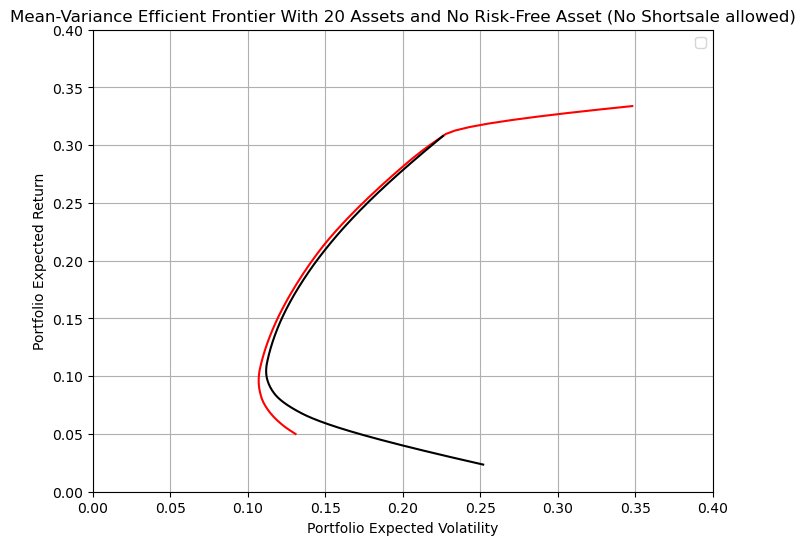

In [236]:
#Checking if our portfolio is indeed better than a random 20 industries
returns_list_F = np.linspace(0.05, 0.5, 150).tolist()

# variance in terms of target return function with no riskfree asset
# Calculate corresponding y values by applying the function to x
sigma_listF = [] #creating empty list
for x in returns_list_F:
    sigma_listF.append(Mean_Variance_Portfolio_20_assets(x,cov_values_5a, z_mean_5a))


# Plotting the Efficient Frontier curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title("Mean-Variance Efficient Frontier With 20 Assets and No Risk-Free Asset (No Shortsale allowed)")
plt.xlabel('Portfolio Expected Volatility')
plt.ylabel('Portfolio Expected Return')
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)
plt.plot(sigma_listF, returns_list_F, color='red')
plt.plot(sigma_list_q3, targetReturns_list_q3, color='black')
'''
plt.plot(vol_ann[0], z_mean[0], marker='o', markersize=4, color='brown', label='Fun')
plt.plot(vol_ann[1], z_mean[1], marker='o', markersize=4, color='red', label='Food')
plt.plot(vol_ann[2], z_mean[2], marker='o', markersize=4, color='blue', label='Trans')
plt.plot(vol_ann[3], z_mean[3], marker='o', markersize=4, color='orange', label='Mines')
plt.plot(vol_ann[4], z_mean[4], marker='o', markersize=4, color='green', label='Banks')
'''
plt.legend()


Question 6

In [255]:
np.random.seed(123)
num_assets = 8

# Importing and dataframe
data = pd.read_csv("48_Portfolios.CSV", index_col=0)

# Convert the index to datetime format
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
last_date = data.index[-1]
start_date = last_date - pd.DateOffset(years=20)

# Filtering for the last 20 years only
data = data[start_date:]
data = data/100
data = data[['Food', 'Beer', 'Drugs', 'Guns', 'Gold', 'Util', 'Chips', 'Meals']]
# Extract covariance matrix
cov_matrix = data.cov()
assets = ['Food', 'Beer', 'Drugs', 'Guns', 'Gold', 'Util', 'Chips', 'Meals']
# Creating EMA

# Create an empty DataFrame to store EMA values
ema = pd.DataFrame()

# Loop over each column to calculate its EMA
span_value = 120
for col in data.columns:
    ema_values = data[col].ewm(span=span_value, adjust=False).mean()
    ema[f"{col}"] = [ema_values.iloc[-1]]
# Annualizing
ema = (ema+1)**12 - 1
# Make ema an array
ema = ema.values[0]

Rf = 0.0552

original_weights = [0.1, 0.3024, 0.1127, 0.1172, 0.0274, 0.1141, 0.1821, 0.0441]

In [256]:
## Monte carlo Simulation

num_resamples = 1000  # Number of resampled portfolios
all_weights = []
target_return = 0.15249524605817516

for _ in range(num_resamples):
    # Resample returns using a multivariate normal distribution
    resampled_returns = np.random.multivariate_normal(ema, cov_matrix)

    # Portfolio optimization using cvxpy for each resampled returns
    weights = cp.Variable(num_assets)

    # Objective: Minimize the portfolio variance
    objective = cp.Minimize(cp.quad_form(weights, cov_matrix))

    # Constraints:
    # 1. The weights should sum up to 1
    # 2. No short-selling (weights >= 0)
    # 3. The expected portfolio return should be equal to target_return
    constraints = [
        cp.sum(weights) == 1,
        weights >= 0,
        cp.matmul(resampled_returns, weights) == target_return
    ]

    # Define the problem and solve
    problem = cp.Problem(objective, constraints)
    problem.solve()

   # If the problem was solved successfully, store the weights
    if problem.status == cp.OPTIMAL:
        all_weights.append(np.array(weights.value).flatten())

# Take the average over all resampled portfolios
average_weights = np.mean(all_weights, axis=0)

print("Resampled Portfolio Weights:", average_weights)

Resampled Portfolio Weights: [0.14637014 0.23543343 0.13469356 0.10242221 0.03118524 0.14019576
 0.15010551 0.05959414]


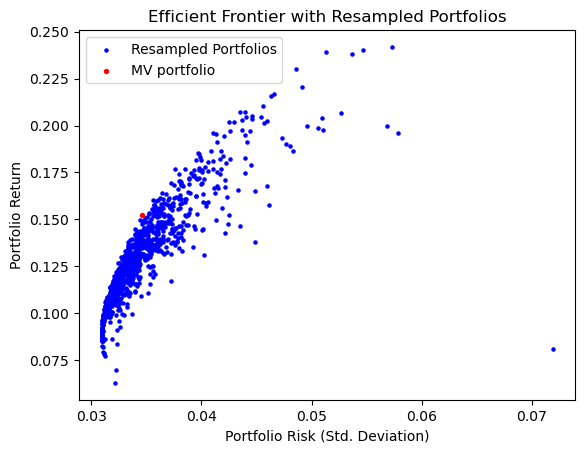

In [259]:
# Efficient Frontier for Resampled portoflios

# Define Portfolio Returns & Risks Functions
def portfolio_return(weights, returns):
    return weights @ returns

def portfolio_risk(weights, cov_matrix):
    return np.sqrt(weights @ cov_matrix @ weights)

resampled_portfolios = []

for i in range(900):
    port_return = portfolio_return(all_weights[i], resampled_returns)
    port_risk = portfolio_risk(all_weights[i], cov_matrix)
    resampled_portfolios.append((port_risk, port_return))   

mv_return = portfolio_return(original_weights, ema)
mv_risk = portfolio_risk(original_weights, cov_matrix)
# Unzipping for plotting
risks, rets = zip(*resampled_portfolios)

# Visualization
plt.scatter(risks, rets, c='blue', s=5, label='Resampled Portfolios')
plt.scatter(mv_risk, mv_return, c='red', s=8, label='MV portfolio')
# Add original MV efficient frontier plotting code here
plt.xlabel('Portfolio Risk (Std. Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier with Resampled Portfolios')
plt.legend()
plt.show()